In [1]:
.libPaths(new = c("/home/paola.benaglio/conda_envs/renv_multiome/lib/R/library",
          "/group/soranzo/paola.benaglio/r_libraries"))

Sys.setenv(RETICULATE_PYTHON="/home/paola.benaglio/conda_envs/renv_multiome/bin/python")
library(reticulate)
reticulate::use_python("/home/paola.benaglio/conda_envs/renv_multiome/bin/python")
reticulate::use_condaenv("/home/paola.benaglio/conda_envs/renv_multiome")
reticulate::py_module_available(module='leidenalg')
reticulate::import('leidenalg') 
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat)) 
suppressMessages(library(Signac)) 
suppressMessages(library(EnsDb.Hsapiens.v86)) 
suppressMessages(library(dplyr)) 
suppressMessages(library(ggplot2)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table)) 
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggplot2))
suppressMessages(library(scDblFinder))



[1] TRUE

Module(leidenalg)

Warning message:
“package ‘Seurat’ was built under R version 4.3.2”
Warning message:
“package ‘Signac’ was built under R version 4.3.2”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.3.2”
Warning message:
“package ‘S4Vectors’ was built under R version 4.3.2”
Warning message:
“package ‘IRanges’ was built under R version 4.3.2”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.3.2”
Warning message:
“package ‘Biobase’ was built under R version 4.3.2”
Warning message:
"package 'SingleCellExperiment' was built under R version 4.3.2"
Warning message:
"package 'SummarizedExperiment' was built under R version 4.3.2"
Warning message:
"package 'MatrixGenerics' was built under R version 4.3.2"


In [1]:
###### MERGING STEP ########################
###### Previously Run as Rscript ############

samples        = c("MCO_1278","MCO_1279", "MCO_1280","MCO_1281")


#### Keep cellbender filtered RNA matrices and remove the ATAC matrices from previous step
adatas <- list()
for (samp in samples){
    adata <- readRDS(sprintf("/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/%s/pre_merge/pre_merged.rds",samp))
    adata@meta.data$orig.ident = sample_name
    adatas[[samp]] <- adata
    DefaultAssay(adatas[[samp]]) <- "RNA"
    adatas[[samp]][['ATAC']] <- NULL
    }
adatas


merged = merge(x =adatas[[1]], y=adatas[2:4], add.cell.ids = samples )
merged

merged[["RNA"]] <-JoinLayers(merged[["RNA"]])
merged

rm(adatas)
gc()


##### Concatenate filtered Long Format ATAC matrices

for (samp in samples){
sample_dir = sprintf("/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/%s/", samp)
lfmat      = read.table(paste0(sample_dir, "snATAC_matrices/", samp, ".long_fmt_mtx.txt.gz"))
lfmat$V1   = paste(samp,lfmat$V1, sep="_" )    
if(samp==samples[1]){
    LFM = lfmat } else {
}
    LFM = rbind(LFM, lfmat)   
}

atac_sm <- with(LFM,
                sparseMatrix(i=as.numeric(as.factor(V2)), j=as.numeric(as.factor(V1)), 
                             x=V3, dimnames=list(levels(as.factor(V2)), levels(as.factor(V1)))))

############################################################
#create the new chromatin assay object and add to Seurat object
############################################################

atac_sm       <- atac_sm[,colnames(merged)]
grange.counts <- StringToGRanges(rownames(atac_sm), sep = c(':', '-'))
grange.use    <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)
atac_sm       <- atac_sm[as.vector(grange.use), ]
suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
seqlevelsStyle(annotations)  <- 'UCSC'
genome(annotations)          <- 'hg38'

frag.file <- "/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/merged.atac_fragments.tsv.gz"
suppressWarnings(chrom_assay <- CreateChromatinAssay(counts=atac_sm, sep=c(':', '-'), 
                                                     genome='hg38', fragments=frag.file, 
                                                     min.cells=-1, min.features=-1, 
                                                     annotation=annotations))



merged[['ATAC']] <- chrom_assay

output_dir = "/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/"
saveRDS(merged, file = file.path(output_dir,'merged_unprocessed.rds'))


[1] TRUE

Module(leidenalg)

Warning message:
“package ‘Seurat’ was built under R version 4.3.2”
Warning message:
“package ‘Signac’ was built under R version 4.3.2”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.3.2”
Warning message:
“package ‘S4Vectors’ was built under R version 4.3.2”
Warning message:
“package ‘IRanges’ was built under R version 4.3.2”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.3.2”
Warning message:
“package ‘Biobase’ was built under R version 4.3.2”


In [2]:
#### From Here
#### Read Merged unprocessed object 
input_dir  = "/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/"
adata = readRDS(file.path(input_dir,'merged_unprocessed.rds'))

#### change accordingly to where you want your data to be written
output_dir = input_dir

In [3]:
adata

An object of class Seurat 
633336 features across 47548 samples within 3 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 2 other assays present: RNA_raw, ATAC

In [4]:
atacm = GetAssayData(adata, layer = "counts", assay = "ATAC")

In [5]:
dim(atacm)

[1] 560134  47548

In [8]:
samples        = c("MCO_1278","MCO_1279", "MCO_1280","MCO_1281")

In [9]:
### Making sure all windows are represented
Windows    = c()
for (samp in samples){
sample_dir = sprintf("/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/%s/", samp)
wind       = readLines(paste0(sample_dir, "snATAC_matrices/", samp, ".regions"))
   Windows = c(Windows, wind)
    }

In [10]:
length(Windows)
length(unique(Windows))

[1] 2234150

[1] 560134

In [11]:
##### Make a list of genes that were corrected by CellBender (QC purposes)
celb_mat    = GetAssayData(adata, layer = "counts", assay = "RNA")
raw_mat     = GetAssayData(adata, layer = "counts", assay = "RNA_raw")
fract       = celb_mat/raw_mat
means       = rowMeans(fract, na.rm=T)
sorted_list = 1-sort(means)
write.csv(data.frame(avg_fraction_removed = sorted_list),paste0(output_dir, "Cellbender_genes.csv"))

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 13.0 GiB"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 13.0 GiB"


In [12]:
## Object needs to be still filtered for doublest
## Below is when filtering for cells that were genotyped
adata2 = subset(adata, subset = No_assigned_GFPbc ==1)

Warning message:
"Removing 32886 cells missing data for vars requested"


In [13]:
## rm cells with 0 rna counts (after cellbender)
adata2 <- adata2[, unname(which( colSums(GetAssayData(adata2, slot = "counts", assay = "RNA"))!=0))]

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead."


In [14]:

### Analyze and cluster without integration
# RNA analysis
DefaultAssay(adata2) <- 'RNA'
adata2
adata2 <- SCTransform(adata2, verbose = FALSE) 
adata2 <- RunPCA(adata2) 
adata2 <- RunUMAP(adata2, dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')


# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata2) <- 'ATAC'
adata2
adata2 <- RunTFIDF(adata2)
adata2 <- FindTopFeatures(adata2, min.cutoff='q0')
adata2 <- RunSVD(adata2)
adata2 <- RunUMAP(adata2, reduction='lsi', dims=2:50, reduction.name='umap.atac', reduction.key='atacUMAP_')


An object of class Seurat 
633336 features across 12683 samples within 3 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 2 other assays present: RNA_raw, ATAC

PC_ 1 
Positive:  AFF3, RBFOX1, AL138828.1, DCLK1, CAPN8, GRAMD2B, INHBA, SH3KBP1, AC013652.1, AL162718.1 
	   STC1, NAV2, NRXN3, IGF1R, GRAMD1B, PPFIBP1, BACE2, REN, ARHGAP26, PTPRM 
	   GZMB, PAEP, MAML3, PDE7B, CGA, TFPI2, FAM107B, PLAC4, BASP1, SVIL 
Negative:  LINC00534, PTH2R, VWDE, HBG2, HBG1, CELF2, STXBP5, HBZ, MEF2C, CCDC26 
	   AC004083.1, PRKAR2B, AIG1, AC109466.1, CPED1, GP1BB, ARL15, ADGRV1, COLGALT2, LINC01033 
	   ACSM3, CALB1, ARHGAP15, SOX6, PTPRC, FADS1, CNST, AC079804.3, GALNT5, HBA1 
PC_ 2 
Positive:  PARD3B, LINC00534, PTH2R, AC016074.2, ZFPM2, AC004083.1, ARL15, STXBP5, VWDE, ADGRV1 
	   CCDC26, AIG1, LINC01811, MEF2C, AC013652.1, LINC02163, AC106744.1, CPED1, PRKCB, SOX6 
	   CELF2, SCHLAP1, BMP2K, AC109466.1, LINC02476, PRKAR2B, LINC02109, AC011287.1, ADGRB3, AC098617.1 
Negative:  TIMP1, RPS18, VIM, EEF1A1, RPL10, RPS24, RPS27A, RPL28, RPS12, FTL 
	   RPL13A, RPLP1, RPS8, RPL19, RPLP2, RPS23, RPS15, RPS19, RPS4X, HSP90AB1 
	   GZMB, RPL37, RPL14, RPS14, RPS11,

An object of class Seurat 
662459 features across 12683 samples within 4 assays 
Active assay: ATAC (560134 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 2 dimensional reductions calculated: pca, umap.rna

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

10:53:12 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

10:53:12 Read 12683 rows and found 49 numeric columns

10:53:12 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

10:53:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:53:13 Writing NN index file to temp file /tmp/Rtmp8qK6g9/filee9ebb25953bca

10:53:13 Searching Annoy index using

In [15]:
# Multimodal analysis
adata2 <- FindMultiModalNeighbors(adata2, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata2 <- RunUMAP(adata2, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata2 <- FindClusters(adata2, graph.name='wsnn', algorithm=4, resolution = 2, verbose=FALSE, method = "igraph")

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

10:55:24 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

10:55:25 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

10:55:28 Initializing from normalized Laplacian + noise (using RSpectra)

10:55:28 Commencing optimization for 200 epochs, with 391680 positive edges

10:55:35 Optimization finished



In [48]:
png(file.path(output_dir,'Merged_clustered_not_itegrated_doublets.png'), width =1000, height = 300)
p1<- DimPlot(adata2, group.by = c("doublet_amulet"), reduction = 'umap.atac', )+ scale_color_manual(values = c("gray", "blue"))
p2<- DimPlot(adata2, group.by = c("scDblFinder.class_atac"), reduction = 'umap.atac', )+ scale_color_manual(values = c("red4", "gray"))
p3<- DimPlot(adata2, group.by = c("scDblFinder.class"), reduction = 'umap.atac', )+ scale_color_manual(values = c("green4", "gray"))


p1 + p2 + p3
dev.off()


png 
  2

In [50]:
options(repr.plot.width = 12, repr.plot.height = 5)
png(file.path(output_dir,'Merged_clustered_not_itegrated.png'), width =1000, height = 350)
p1 <- DimPlot(adata2, reduction = "umap.rna", group.by = "seurat_clusters", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(adata2, reduction = "umap.atac", group.by = "seurat_clusters", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "seurat_clusters", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))
dev.off()


options(repr.plot.width = 14, repr.plot.height = 8)
png(file.path(output_dir,'Merged_clustered_not_itegrated_qc.png'), width =1000, height = 400)
p6 <- FeaturePlot(adata2, features = c("nCount_SCT", "nCount_RNA", "nCount_ATAC",'TSS.enrichment'), ncol = 4,
                  reduction = 'umap.wnn')
p7 <- FeaturePlot(adata2, features = c("nFeature_SCT", "nFeature_RNA", "nFeature_ATAC",'percent.mt'), ncol = 4,
                  reduction = 'umap.wnn')
p6 / p7
dev.off()



options(repr.plot.width = 12, repr.plot.height = 6)
png(file.path(output_dir,'Merged_clustered_not_itegrated_unique_GFP_bc.png'), width =1000, height = 600)
p1<- DimPlot(adata2, reduction = "umap.rna", group.by = "Assigned_GFPbc", label.size = 2.5, repel = TRUE) + ggtitle("RNA") 
p2<- DimPlot(adata2, reduction = "umap.atac", group.by = "Assigned_GFPbc", label.size = 2.5, repel = TRUE) + ggtitle("ATAC")
p3<- DimPlot(adata2, reduction = "umap.wnn", group.by = "Assigned_GFPbc", label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p4<- DimPlot(adata2, reduction = "umap.wnn", group.by = "Assigned_GFPgenotype", label.size = 2.5, repel = TRUE) + ggtitle("WNN")

p1 + p2 +p3 +p4 
dev.off()


png 
  2

png 
  2

png 
  2

png 
  2

In [41]:
options(repr.plot.width = 12, repr.plot.height = 5)
png(file.path(output_dir,'Merged_clustered_not_itegrated_bysample.png'), width =1000, height = 350)
p1 <- DimPlot(adata2, reduction = "umap.rna", group.by = "orig.ident", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(adata2, reduction = "umap.atac", group.by = "orig.ident", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "orig.ident", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))
dev.off()

png 
  2

In [19]:

png(file.path(output_dir,'Merged_clustered_not_itegrated_bysample_wnn.png'), width =500, height = 350)
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "orig.ident", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p3  & theme(plot.title = element_text(hjust = 0.5))
dev.off()

png(file.path(output_dir,'Merged_clustered_not_itegrated_byGT_wnn.png'), width =500, height = 350)
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "Assigned_GFPgenotype", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p3  & theme(plot.title = element_text(hjust = 0.5))
dev.off()

png 
  2

In [28]:
adata

An object of class Seurat 
633336 features across 47548 samples within 3 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 2 other assays present: RNA_raw, ATAC

In [26]:
table(adata2@meta.data[,c("Assigned_GFPgenotype","orig.ident" )])

                    orig.ident
Assigned_GFPgenotype MCO_1278 MCO_1279 MCO_1280 MCO_1281
            16bp_del     1274      583      473      692
            80bp_del     1139      716      577      702
            HET           570      871      331      331
            MUT           258      576      273      339
            WT            565      722      814      877

In [54]:
adata2@meta.data$doublet= with(adata2@meta.data, doublet_amulet == TRUE & 
                               scDblFinder.class_atac=="doublet" & scDblFinder.class=="doublet")

In [55]:
sum(adata2@meta.data$doublet)

[1] 951

In [56]:
adata3 = subset(adata2, doublet == FALSE )

adata3 = subset(adata3, seurat_clusters!=13)

In [59]:
adata3

An object of class Seurat 
662459 features across 11250 samples within 4 assays 
Active assay: ATAC (560134 features, 560134 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

In [61]:
table(adata3@meta.data[,c("Assigned_GFPgenotype","orig.ident" )])

                    orig.ident
Assigned_GFPgenotype MCO_1278 MCO_1279 MCO_1280 MCO_1281
            16bp_del     1101      505      374      595
            80bp_del     1043      649      482      634
            HET           520      774      288      296
            MUT           243      532      239      312
            WT            525      666      680      792

In [60]:
12683-11250

[1] 1433

In [51]:
table(with(adata2@meta.data, doublet_amulet ))
table(with(adata2@meta.data, scDblFinder.class_atac))
  table(with(adata2@meta.data,    scDblFinder.class))


FALSE  TRUE 
10453  2230 


doublet singlet 
   2943    9740 


doublet singlet 
   4215    8468 

In [42]:
table(meta_test[,c("Assigned_GFPgenotype","orig.ident" )])

                    orig.ident
Assigned_GFPgenotype MCO_1278 MCO_1279 MCO_1280 MCO_1281
            16bp_del      706      278      177      359
            80bp_del      743      385      236      398
            HET           350      445      130      194
            MUT           158      321      104      195
            WT            341      402      300      475

In [46]:
sum(adata2@meta.data$seurat_clusters==13)

[1] 488

### Plots below to decide on a filtering strategy

In [51]:

p1 <- VlnPlot(adata2, features='nCount_SCT', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$nCount_SCT), linetype='dashed')
p2 <- VlnPlot(adata2, features='nFeature_SCT', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$nFeature_SCT), linetype='dashed')
p3 <- VlnPlot(adata2, features='nCount_ATAC', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$nCount_ATAC), linetype='dashed')
p4 <- VlnPlot(adata2, features='nFeature_ATAC', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$nFeature_ATAC), linetype='dashed')
p5 <- VlnPlot(adata2, features='nCount_RNA', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$nCount_SCT), linetype='dashed')
p6 <- VlnPlot(adata2, features='nFeature_RNA', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$nFeature_SCT), linetype='dashed')


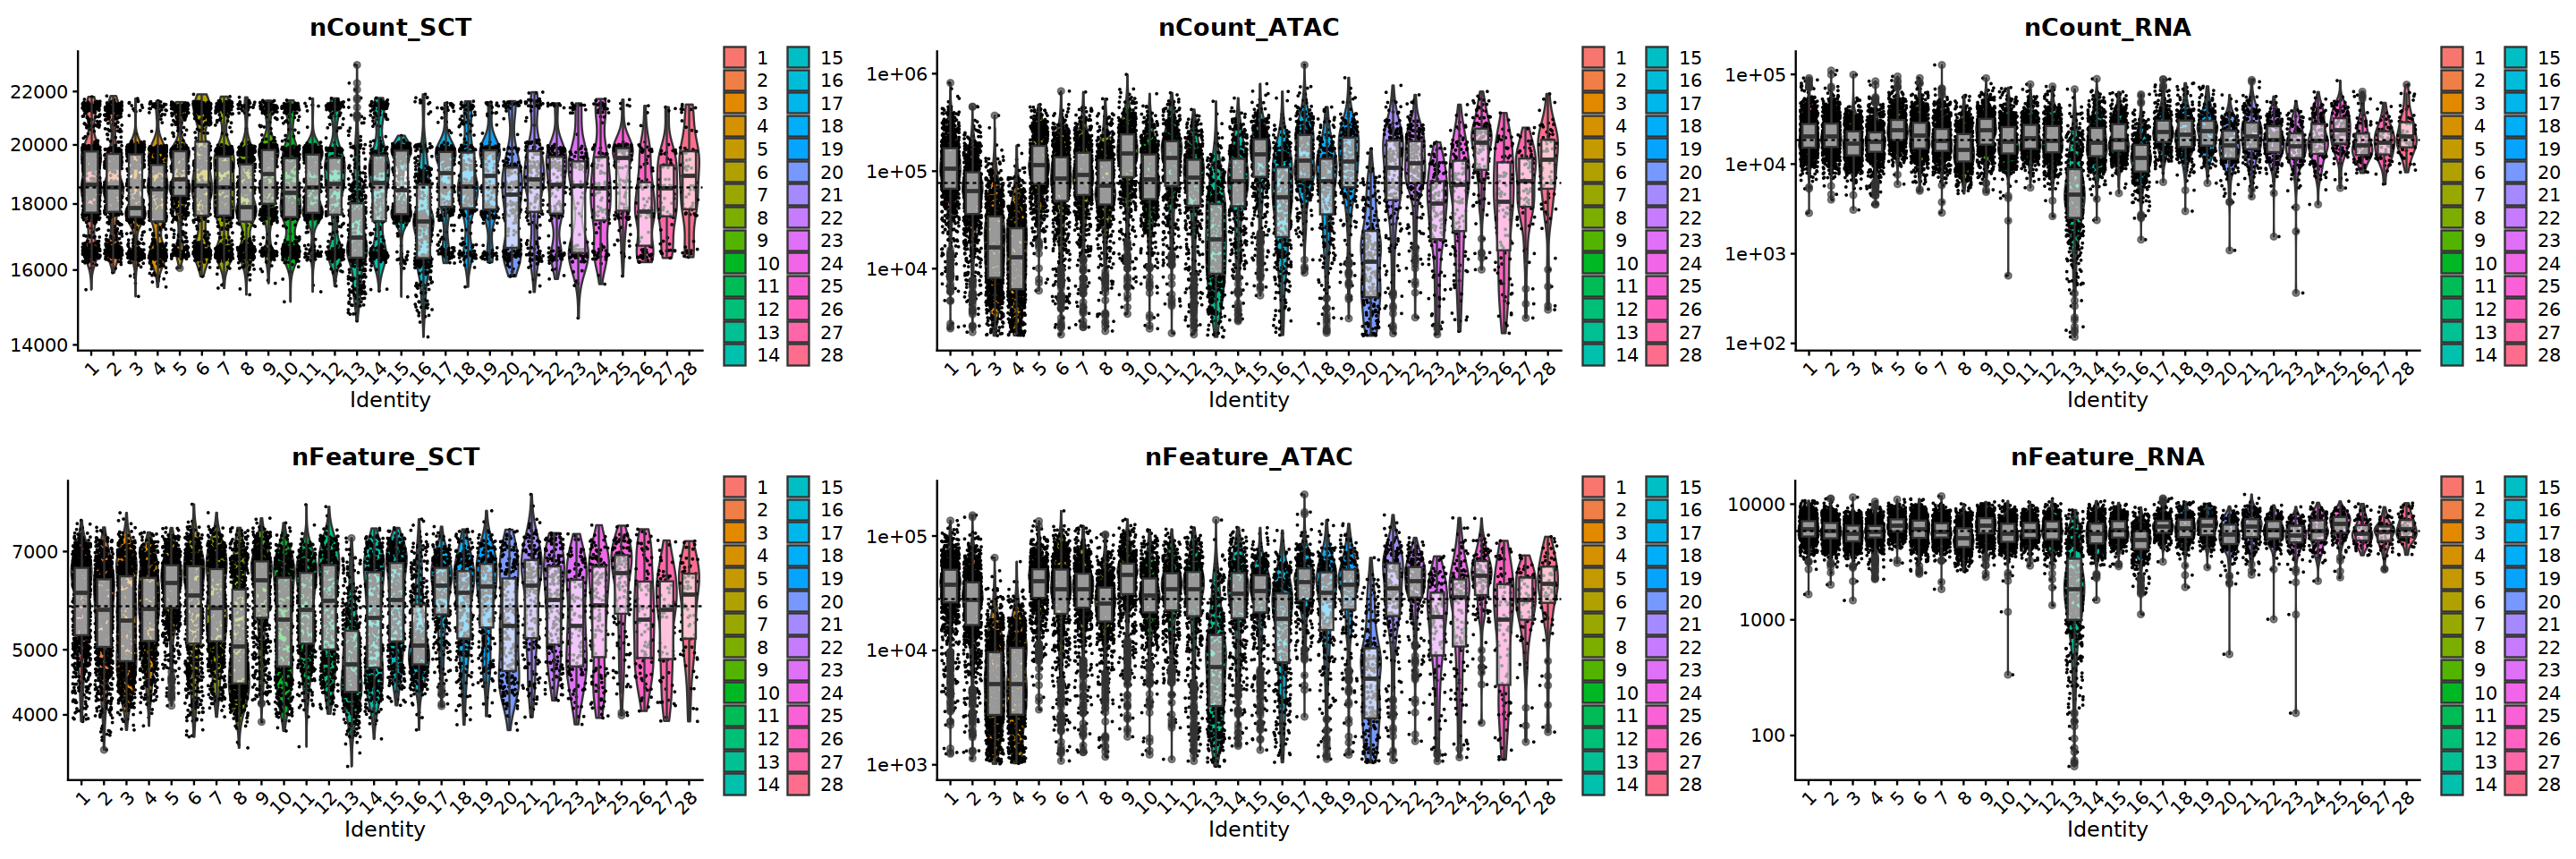

In [52]:
options(repr.plot.width=24, repr.plot.height=8)
ggarrange(p1, p3, p5, p2, p4, p6, ncol = 3, nrow = 2)


In [53]:
colnames(adata2@meta.data)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "gex_raw_reads"                     "gex_mapped_reads"                 
[11] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[13] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[15] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[17] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[19] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[21] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[23] "gex_umis_count"                    "gex_genes_count"                  
[25] "atac_raw_reads"                    "atac_unmapped_reads"              
[27] "atac_lowmapq"                      "atac_dup_reads"                   
[29] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[31] "atac_fragments"                    "atac_TSS_fragments"               
[33] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[35] "TSS.enrichment"                    "TSS.percentile"                   
[37] "scDblFinder.class"                 "scDblFinder.score"                
[39] "scDblFinder.weighted"              "scDblFinder.cxds_score"           
[41] "scDblFinder.class_atac"            "scDblFinder.score_atac"           
[43] "scDblFinder.weighted_atac"         "scDblFinder.cxds_score_atac"      
[45] "No_assigned_GFPbc"                 "Assigned_GFPbc"                   
[47] "Assigned_GFPgenotype"              "DBL_comb"                         
[49] "amulet_nFrags"                     "amulet_uniqFrags"                 
[51] "amulet_nAbove2"                    "amulet_total.nAbove2"             
[53] "amulet_p.value"                    "amulet_q.value"                   
[55] "doublet_amulet"                    "nCount_SCT"                       
[57] "nFeature_SCT"                      "SCT.weight"                       
[59] "ATAC.weight"                       "wsnn_res.0.2"                     
[61] "seurat_clusters"                   "wsnn_res.2"

In [43]:
p9 <- VlnPlot(adata2, features='TSS.enrichment', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$TSS.enrichment), linetype='dashed')
p10 <- VlnPlot(adata2, features='percent.mt', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$percent.mt), linetype='dashed')
p11 <- VlnPlot(adata2, features='amulet_nFrags', group.by='seurat_clusters', log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$amulet_nFrags), linetype='dashed')


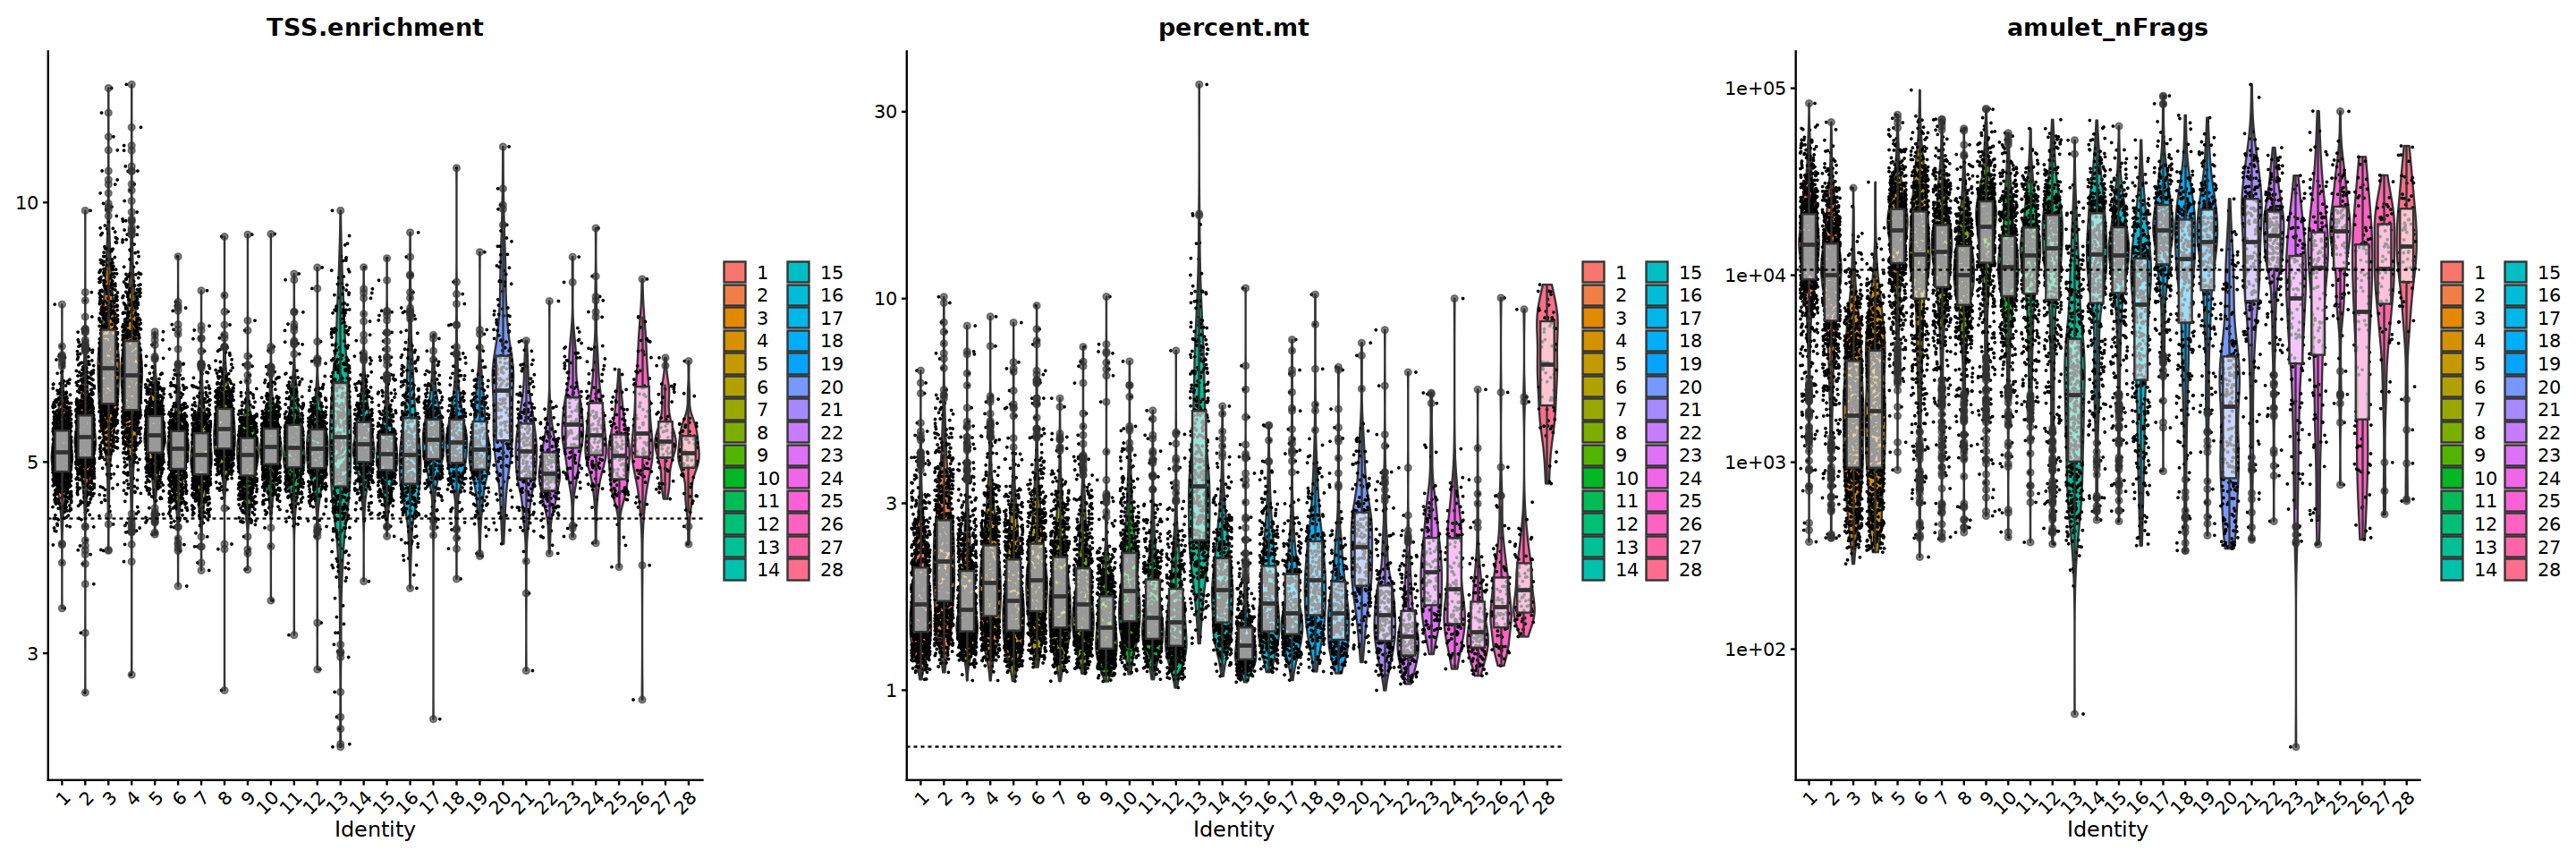

In [45]:
options(repr.plot.width=24, repr.plot.height=8)
ggarrange(p9,p10,p11 ,ncol= 3, nrow = 1)


In [65]:
p9 <- VlnPlot(adata2, features='scDblFinder.score', group.by='seurat_clusters') + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$scDblFinder.score), linetype='dashed')
p10 <- VlnPlot(adata2, features='scDblFinder.score_atac', group.by='seurat_clusters') + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata2$scDblFinder.score_atac), linetype='dashed')


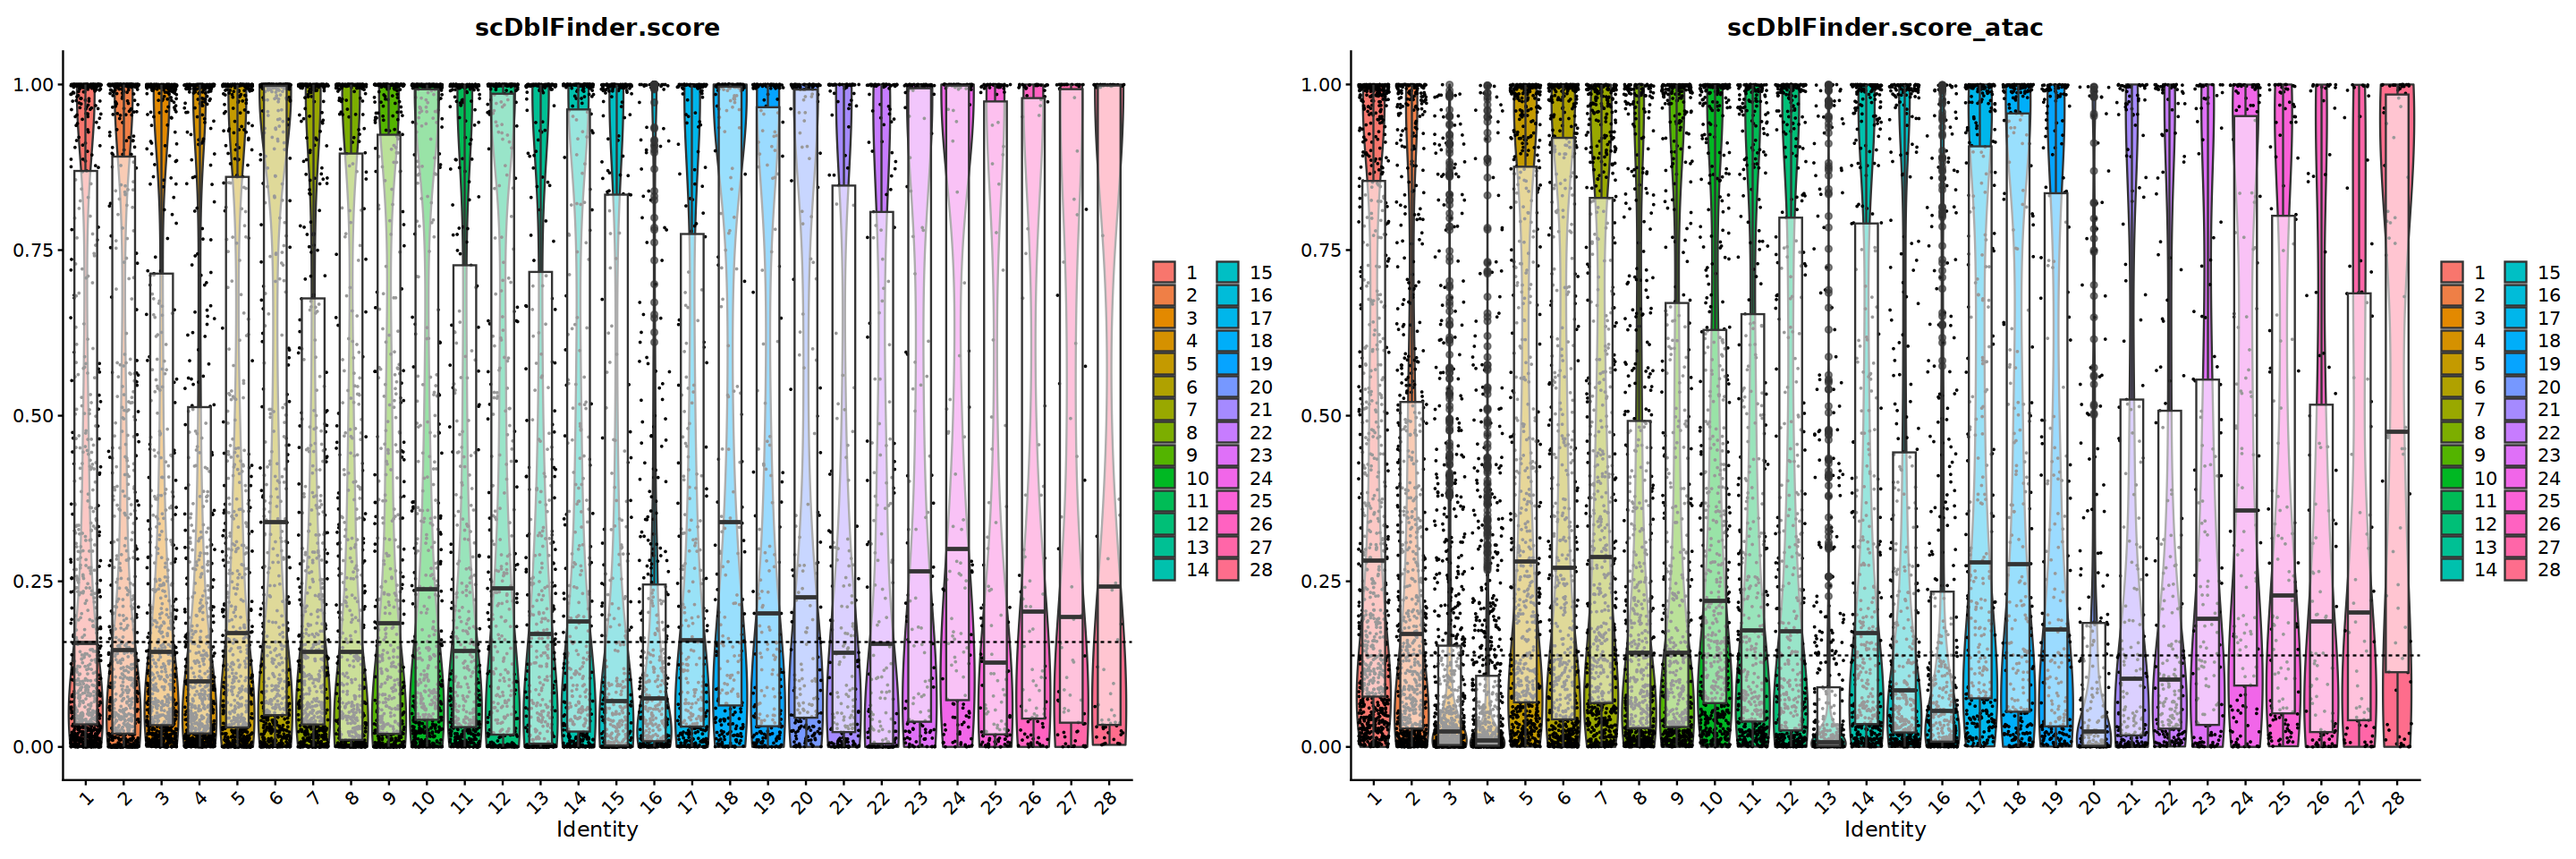

In [66]:
ggarrange(p9,p10 ,ncol= 2, nrow = 1)

In [71]:
bp=adata2@meta.data[,c('scDblFinder.score_atac','scDblFinder.class_atac')]

In [62]:
saveRDS(adata2, file = file.path(output_dir,'merged_genotyped_clustered.rds'))

In [63]:
### Analyze and cluster without integration
# RNA analysis
adata2 <- adata3  ##(replace object)
DefaultAssay(adata2) <- 'RNA'
adata2
adata2 <- SCTransform(adata2, verbose = FALSE) 
adata2 <- RunPCA(adata2) 
adata2 <- RunUMAP(adata2, dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')


# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata2) <- 'ATAC'
adata2
adata2 <- RunTFIDF(adata2)
adata2 <- FindTopFeatures(adata2, min.cutoff='q0')
adata2 <- RunSVD(adata2)
adata2 <- RunUMAP(adata2, reduction='lsi', dims=2:50, reduction.name='umap.atac', reduction.key='atacUMAP_')

# Multimodal analysis
adata2 <- FindMultiModalNeighbors(adata2, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata2 <- RunUMAP(adata2, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata2 <- FindClusters(adata2, graph.name='wsnn', algorithm=4, resolution = 2, verbose=FALSE, method = "igraph")

An object of class Seurat 
662459 features across 11250 samples within 4 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 layer present: counts
 3 other assays present: RNA_raw, ATAC, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

Warning message:
"Different cells and/or features from existing assay SCT"
PC_ 1 
Positive:  AFF3, RBFOX1, DCLK1, AL138828.1, CAPN8, GRAMD2B, INHBA, SH3KBP1, AL162718.1, STC1 
	   AC013652.1, NAV2, IGF1R, NRXN3, GRAMD1B, PPFIBP1, GZMB, BACE2, PAEP, REN 
	   ARHGAP26, PTPRM, CCL2, TFPI2, CCL3L1, PDE7B, CGA, MAML3, FAM107B, BASP1 
Negative:  LINC00534, PTH2R, VWDE, CELF2, STXBP5, CCDC26, AC004083.1, MEF2C, PRKAR2B, HBZ 
	   HBG2, AIG1, HBG1, CPED1, ARL15, AC109466.1, GP1BB, ADGRV1, LINC01033, ACSM3 
	   COLGALT2, CALB1, SOX6, ARHGAP15, AC079804.3, CNST, GALNT5, AC011287.1, FADS1, RAB27B 
PC_ 2 
Positive:  LINC00534, PARD3B, PTH2R, ADGRB3, CGA, AC109466.1, MEF2C, AC004083.1, CALB1, RELN 
	   ZFPM2, SOX6, REN, AFF3, AIG1, CBLB, VWDE, RBFOX1, ARL15, GRAMD1B 
	   NRXN3, CELF2, CCDC80, SGO1-AS1, PRKAR2B, CAPN8, STXBP5, AC011287.1, ATP8A2, ADGRV1 
Negative:  DIAPH3, PCDH9, ASPM, ERVMER61-1, TOP2A, LINC00861, BRIP1, AC015574.1, RRM2, MKI67 
	   KIF14, CENPF, ARHGAP11B, POLQ, AC069277.1, ATAD2, 

An object of class Seurat 
662095 features across 11250 samples within 4 assays 
Active assay: ATAC (560134 features, 560134 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

12:58:50 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:58:50 Read 11250 rows and found 49 numeric columns

12:58:50 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:58:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:58:51 Writing NN index file to temp file /tmp/Rtmp8qK6g9/filee9ebb36de397b

12:58:51 Searching Annoy index using

In [68]:
adata2 <- FindClusters(adata2, graph.name='wsnn', algorithm=4, resolution = 0.5, verbose=FALSE, method = "igraph")

Warning message in paste(el[, 1], el[, 2], sep = "|"):
"NAs introduced by coercion to integer range"
Warning message in paste(el[, 1], el[, 2], sep = "|"):
"NAs introduced by coercion to integer range"
Warning message in deparse(substitute(arg)):
"NAs introduced by coercion to integer range"
Warning message in paste0("igraph::", x):
"NAs introduced by coercion to integer range"
Warning message in deparse(x[[1L]]):
"NAs introduced by coercion to integer range"
Warning message in deparse(expr, width.cutoff, ...):
"NAs introduced by coercion to integer range"
Warning message in paste(deparse(expr, width.cutoff, ...), collapse = collapse):
"NAs introduced by coercion to integer range"
Warning message in deparse(x[[1L]]):
"NAs introduced by coercion to integer range"
Warning message in deparse(expr, width.cutoff, ...):
"NAs introduced by coercion to integer range"
Warning message in paste(deparse(expr, width.cutoff, ...), collapse = collapse):
"NAs introduced by coercion to integer range"
W

In [64]:
png(file.path(output_dir,'Merged_clustered_not_itegrated_bysample_wnn_filt.png'), width =500, height = 350)
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "orig.ident", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p3  & theme(plot.title = element_text(hjust = 0.5))
dev.off()

png(file.path(output_dir,'Merged_clustered_not_itegrated_byGT_wnn_filt.png'), width =500, height = 350)
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "Assigned_GFPgenotype", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p3  & theme(plot.title = element_text(hjust = 0.5))
dev.off()

png 
  2

png 
  2

In [69]:
png(file.path(output_dir,'Merged_clustered_not_itegrated_byclus_wnn_filt.png'), width =500, height = 350)
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "seurat_clusters", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p3  & theme(plot.title = element_text(hjust = 0.5))
dev.off()

png 
  2

In [65]:
options(repr.plot.width = 14, repr.plot.height = 8)
png(file.path(output_dir,'Merged_clustered_not_itegrated_qc_filt.png'), width =1000, height = 400)
p6 <- FeaturePlot(adata2, features = c("nCount_SCT", "nCount_RNA", "nCount_ATAC",'TSS.enrichment'), ncol = 4,
                  reduction = 'umap.wnn')
p7 <- FeaturePlot(adata2, features = c("nFeature_SCT", "nFeature_RNA", "nFeature_ATAC",'percent.mt'), ncol = 4,
                  reduction = 'umap.wnn')
p6 / p7
dev.off()


png 
  2

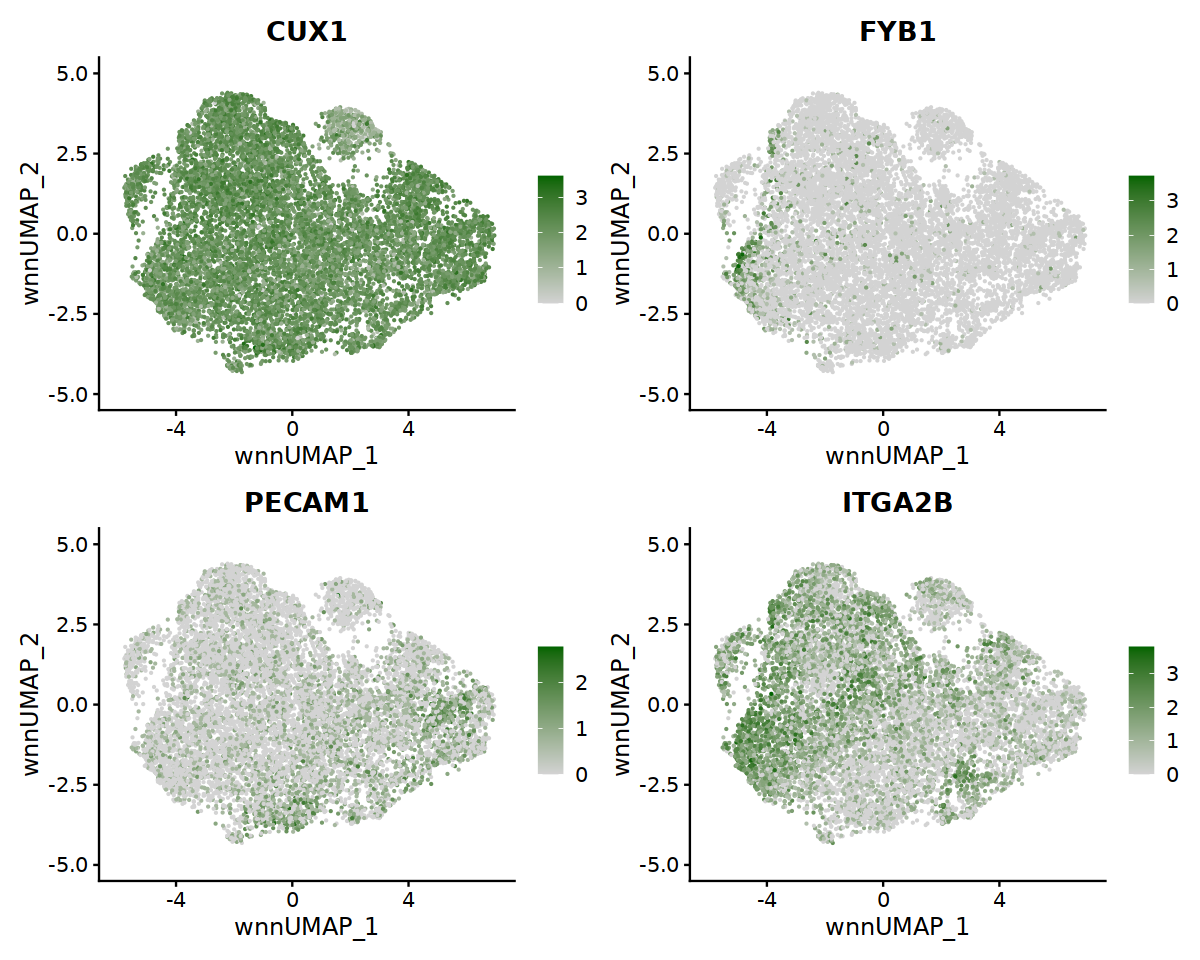

In [78]:
options(repr.plot.width = 10, repr.plot.height = 8)
DefaultAssay(adata2) <- 'SCT'
FeaturePlot(adata2, features = c("CUX1",'FYB1', 'PECAM1', 'ITGA2B'),
                  reduction = 'umap.wnn', 
                  cols = c("lightgrey","darkgreen"), ncol = 2)

### Call Peaks and make new peak matrix

In [2]:
output_dir = "/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/"

In [3]:
adata2= readRDS(file = file.path(output_dir,'merged_genotyped_clustered.rds'))

In [6]:
adata2

An object of class Seurat 
662459 features across 11250 samples within 4 assays 
Active assay: ATAC (560134 features, 560134 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

In [5]:
adata2 = subset(adata2, doublet == FALSE )
adata2 = subset(adata2, seurat_clusters!=13)

In [7]:
DefaultAssay(adata2) <- 'ATAC'
peaks <- CallPeaks(
  object = adata2,
  macs2.path = "/home/paola.benaglio/conda_envs/python_snatac/bin/macs2"
)

In [10]:
length(peaks)

[1] 356958

In [11]:
frag.file <- "/group/soranzo/paola.benaglio/k562_multiome/processing_outputs/merged.atac_fragments.tsv.gz"
Fragmobj <- CreateFragmentObject(frag.file,cells =Cells(adata2) )

Computing hash



In [12]:
peakmat = FeatureMatrix(fragments = Fragmobj, features = peaks, cells = Cells(adata2), process_n = 10000,
                        sep = c(":", "-"), verbose = TRUE)

Extracting reads overlapping genomic regions



In [32]:
norm_chr = rownames(peakmat)[stringr::str_split_fixed(rownames(peakmat), "\\:",2)[,1] %in% 
                             paste0("chr", c(1:22, "X", "Y"))]

In [33]:
peakmat=peakmat[norm_chr,]

In [34]:
dim(peakmat)

[1] 356772  11250

In [19]:
suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
seqlevelsStyle(annotations)  <- 'UCSC'
genome(annotations)          <- 'hg38'

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [36]:
suppressWarnings(chrom_assay <- CreateChromatinAssay(counts=peakmat, sep=c(':', '-'), 
                                                     genome='hg38', fragments=Fragmobj, 
                                                     min.cells=-1, min.features=-1, 
                                                     annotation=annotations))



adata2[['ATAC']] <- chrom_assay

Warning message:
"Different cells and/or features from existing assay ATAC"


### Recluster with new ATAC

In [38]:
# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata2) <- 'ATAC'
adata2
adata2 <- RunTFIDF(adata2)
adata2 <- FindTopFeatures(adata2, min.cutoff='q0')
adata2 <- RunSVD(adata2)
adata2 <- RunUMAP(adata2, reduction='lsi', dims=2:50, reduction.name='umap.atac', reduction.key='atacUMAP_')

# Multimodal analysis
adata2 <- FindMultiModalNeighbors(adata2, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata2 <- RunUMAP(adata2, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')


An object of class Seurat 
459097 features across 11250 samples within 4 assays 
Active assay: ATAC (356772 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
14:57:13 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

14:57:13 Read 11250 rows and found 49 numeric columns

14:57:13 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

14:57:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


In [40]:
adata2 <- FindClusters(adata2, graph.name='wsnn', algorithm=4, resolution = 0.5, verbose=FALSE, method = "igraph")

Warning message in paste(el[, 1], el[, 2], sep = "|"):
"NAs introduced by coercion to integer range"
Warning message in paste(el[, 1], el[, 2], sep = "|"):
"NAs introduced by coercion to integer range"
Warning message in deparse(substitute(arg)):
"NAs introduced by coercion to integer range"
Warning message in paste0("igraph::", x):
"NAs introduced by coercion to integer range"
Warning message in deparse(x[[1L]]):
"NAs introduced by coercion to integer range"
Warning message in deparse(expr, width.cutoff, ...):
"NAs introduced by coercion to integer range"
Warning message in paste(deparse(expr, width.cutoff, ...), collapse = collapse):
"NAs introduced by coercion to integer range"
Warning message in deparse(x[[1L]]):
"NAs introduced by coercion to integer range"
Warning message in deparse(expr, width.cutoff, ...):
"NAs introduced by coercion to integer range"
Warning message in paste(deparse(expr, width.cutoff, ...), collapse = collapse):
"NAs introduced by coercion to integer range"
W

In [42]:

png(file.path(output_dir,'New_merged_bycluster.png'), width =1000, height = 350)
p1 <- DimPlot(adata2, reduction = "umap.rna", group.by = "seurat_clusters", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(adata2, reduction = "umap.atac", group.by = "seurat_clusters", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(adata2, reduction = "umap.wnn", group.by = "seurat_clusters", label = TRUE, label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p1 + p2 + p3  & theme(plot.title = element_text(hjust = 0.5))
dev.off()

png(file.path(output_dir,'New_merged_byGFP_bc.png'), width =1200, height = 350)
p1<- DimPlot(adata2, reduction = "umap.rna", group.by = "Assigned_GFPbc", label.size = 2.5, repel = TRUE) + ggtitle("RNA") 
p2<- DimPlot(adata2, reduction = "umap.atac", group.by = "Assigned_GFPbc", label.size = 2.5, repel = TRUE) + ggtitle("ATAC")
p3<- DimPlot(adata2, reduction = "umap.wnn", group.by = "Assigned_GFPbc", label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p1 + p2 +p3
dev.off()
png(file.path(output_dir,'New_merged_byGFPgt_bc.png'), width =1200, height = 350)
p1<- DimPlot(adata2, reduction = "umap.rna", group.by = "Assigned_GFPgenotype", label.size = 2.5, repel = TRUE) + ggtitle("RNA") 
p2<- DimPlot(adata2, reduction = "umap.atac", group.by = "Assigned_GFPgenotype", label.size = 2.5, repel = TRUE) + ggtitle("ATAC")
p3<- DimPlot(adata2, reduction = "umap.wnn", group.by = "Assigned_GFPgenotype", label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p1 + p2 +p3
dev.off()

png(file.path(output_dir,'New_merged_bysample.png'), width =1200, height = 350)
p1<- DimPlot(adata2, reduction = "umap.rna", group.by = "orig.ident", label.size = 2.5, repel = TRUE) + ggtitle("RNA") 
p2<- DimPlot(adata2, reduction = "umap.atac", group.by = "orig.ident", label.size = 2.5, repel = TRUE) + ggtitle("ATAC")
p3<- DimPlot(adata2, reduction = "umap.wnn", group.by = "orig.ident", label.size = 2.5, repel = TRUE) + ggtitle("WNN")
p1 + p2 +p3
dev.off()


options(repr.plot.width = 14, repr.plot.height = 8)
png(file.path(output_dir,'New_merged_qc.png'), width =1000, height = 400)
p6 <- FeaturePlot(adata2, features = c("nCount_SCT", "nCount_RNA", "nCount_ATAC",'TSS.enrichment'), ncol = 4,
                  reduction = 'umap.wnn')
p7 <- FeaturePlot(adata2, features = c("nFeature_SCT", "nFeature_RNA", "nFeature_ATAC",'percent.mt'), ncol = 4,
                  reduction = 'umap.wnn')
p6 / p7
dev.off()





png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [43]:
saveRDS(adata2, file = file.path(output_dir,'merged_filtered_atacPeaks.rds'))

### Quick check of differential genes by genotypes to confirm bulk results

In [54]:
DefaultAssay(adata2) <- 'SCT'
Idents(adata2) <- "Assigned_GFPgenotype"
de_mut <- FindMarkers(adata2, ident.1 = "MUT", ident.2 = "WT", verbose = FALSE)

In [73]:
adata2$new_categ = paste( adata2$orig.ident, adata2$Assigned_GFPgenotype, sep=".")

In [74]:
unique(adata2$new_categ)

[1] "MCO_1278.16bp_del" "MCO_1278.80bp_del" "MCO_1278.HET"     
 [4] "MCO_1278.WT"       "MCO_1278.MUT"      "MCO_1279.80bp_del"
 [7] "MCO_1279.16bp_del" "MCO_1279.HET"      "MCO_1279.MUT"     
[10] "MCO_1279.WT"       "MCO_1280.80bp_del" "MCO_1280.WT"      
[13] "MCO_1280.HET"      "MCO_1280.16bp_del" "MCO_1280.MUT"     
[16] "MCO_1281.WT"       "MCO_1281.80bp_del" "MCO_1281.16bp_del"
[19] "MCO_1281.HET"      "MCO_1281.MUT"

In [76]:
Idents(adata2) <- "new_categ"
de_mut24h <- FindMarkers(adata2, ident.1 = "MCO_1278.MUT", ident.2 = "MCO_1278.WT", verbose = FALSE)

In [77]:
#de_het <- FindMarkers(adata2, ident.1 = "HET", ident.2 = "WT", verbose = FALSE)

In [78]:
#de_del16 <- FindMarkers(adata2, ident.1 = "16bp_del", ident.2 = "WT", verbose = FALSE)

In [79]:
#de_del80 <- FindMarkers(adata2, ident.1 = "80bp_del", ident.2 = "WT", verbose = FALSE)

In [84]:
head(de_mut24h,10)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
AC092957.1 2.395015e-22 -3.2302115 0.066 0.413 6.975003e-18
XACT       2.292454e-21  2.8054959 0.457 0.154 6.676315e-17
SND1       8.686554e-18 -0.5131972 0.992 1.000 2.529785e-13
CUX1       6.820508e-17 -0.5018603 0.996 0.994 1.986336e-12
CALU       3.740326e-16 -0.5043875 0.988 0.996 1.089295e-11
KMT2E      4.746760e-15 -0.4912682 0.988 1.000 1.382399e-10
AC019197.1 6.183459e-15 -0.8140450 0.765 0.903 1.800809e-10
LINC02671  1.181049e-14  4.0748352 0.136 0.008 3.439569e-10
LINC02315  2.399885e-14  2.2882389 0.300 0.091 6.989186e-10
ITGA4      2.568999e-14  6.6349231 0.107 0.000 7.481694e-10

In [111]:
sum(de_mut24h$p_val_adj<0.1)

[1] 127

In [130]:
writeLines(rownames(de_mut24h[de_mut24h$p_val_adj<0.1,]))

AC092957.1
XACT
SND1
CUX1
CALU
KMT2E
AC019197.1
LINC02671
LINC02315
ITGA4
LINC02008
SRPK2
AKAP9
FBXL13
ELMO1
CELF2
ZNF521
PARD3B
EXOC4
CNTN5
PDIA4
BRAF
AC097520.2
CTAG2
RHEB
LINC02307
MKLN1
AL451048.1
AC008825.1
GRID2
UBE3C
ZNF85
POLR2J3
AC020687.1
HPD
AL035446.2
DNAJC2
LINC01004
TIMP1
KMT2C
AL713998.3
SQLE
LPCAT2
MEIS1
EDARADD
SSX3
DOCK2
INPP5D
TMEM158
RBM33
LINC02476
ANO5
LUC7L2
RAB27B
LINC01088
PRKRIP1
FYB1
SCHLAP1
AC016687.3
ESYT2
BCOR
TSPAN5
SCN2A
GPC6
ANKRD33B
KLHDC10
LINC00355
UCA1
AC139493.2
AP001531.1
SLCO1B1
TMEM209
RABGEF1
ZNF680
MIR548XHG
LINC02141
LINC02109
RARB
AF279873.3
ITGAV
ST8SIA6
WASL
C16orf95
AC005381.1
YWHAG
SEC24D
MT-CO1
AGAP1
AC016723.1
AL713998.1
ZNF790
LINC02577
VKORC1L1
AC008568.1
ZNF212
BAIAP2L1
AC078845.1
AL646090.2
IGFBP4
IMMP2L
SLC37A1
SPPL3
ORC5
MAGED1
TXK
MS4A4A
MYB
NCOA2
AP001528.1
ST7
AP005262.2
PHTF2
AIG1
MKRN1
DIRAS3
PIP4K2A
AC025569.1
AHCYL2
CHST11
CUL1
POT1
RUNX1
POM121C
ETV6
SLC38A2
TMEM168
LINC01169


In [112]:
mm = merge(de_mut24h, alt_exp, by.x = "row.names", by.y="Symbol" )

In [115]:
fisher.test(table(mm$p_val_adj<0.1, mm$fdr<0.1))


	Fisher's Exact Test for Count Data

data:  table(mm$p_val_adj < 0.1, mm$fdr < 0.1)
p-value = 1.146e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  7.158442 55.200081
sample estimates:
odds ratio 
  21.68977 


In [117]:
mm[mm$p_val_adj<0.1& mm$fdr<0.1,1]

[1] "CUL1"   "DNAJC2" "ESYT2"  "ORC5"   "PDIA4"  "UBE3C" 

In [134]:
cor.test(mm$avg_log2FC, mm$logFC)


	Pearson's product-moment correlation

data:  mm$avg_log2FC and mm$logFC
t = 31.15, df = 8937, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2941294 0.3315318
sample estimates:
      cor 
0.3129519 


In [136]:
summary(lm(avg_log2FC~logFC, mm))


Call:
lm(formula = avg_log2FC ~ logFC, data = mm)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1331 -0.2586 -0.0433  0.2588  5.7285 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.023654   0.005911  -4.002 6.34e-05 ***
logFC        0.231939   0.007446  31.150  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5586 on 8937 degrees of freedom
Multiple R-squared:  0.09794,	Adjusted R-squared:  0.09784 
F-statistic: 970.3 on 1 and 8937 DF,  p-value: < 2.2e-16


In [138]:
mm$signif = mm$p_val_adj<0.1 | mm$fdr<0.1

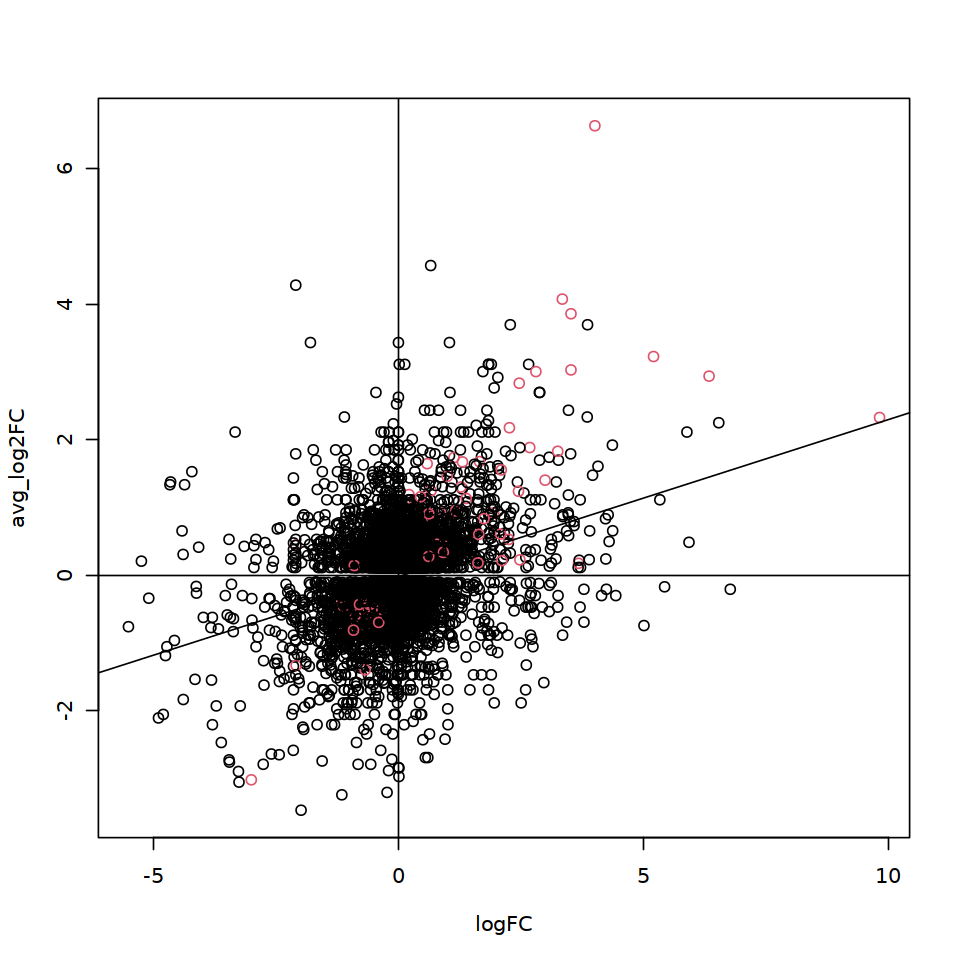

In [139]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot(avg_log2FC~logFC, mm,col = mm$signif+1 )
abline(h=0,v=0)
abline(lm(avg_log2FC~logFC, mm))

In [57]:
exp_res = read.table("/group/soranzo/manuel.tardaguila/Bulk_RNA_seq/RITM0022181_2/Repetition_LIP/DE_edgeR_results.tsv",
                    header=T) 

In [81]:
alt_exp = subset(exp_res,comparison == "homALT_vs_wt" & time_point=="24_hrs")

In [107]:
alt_exp$fdr = p.adjust(10^(-alt_exp$Minus_logpval))

In [110]:
sum(alt_exp$fdr<0.1)

[1] 37

In [108]:
subset(alt_exp, Symbol=="CUX1")

ensembl_gene_id Symbol Minus_logpval logFC      time_point comparison  
39524 ENSG00000257923 CUX1   3.452392      -0.8314859 24_hrs     homALT_vs_wt
      fdr
39524 1

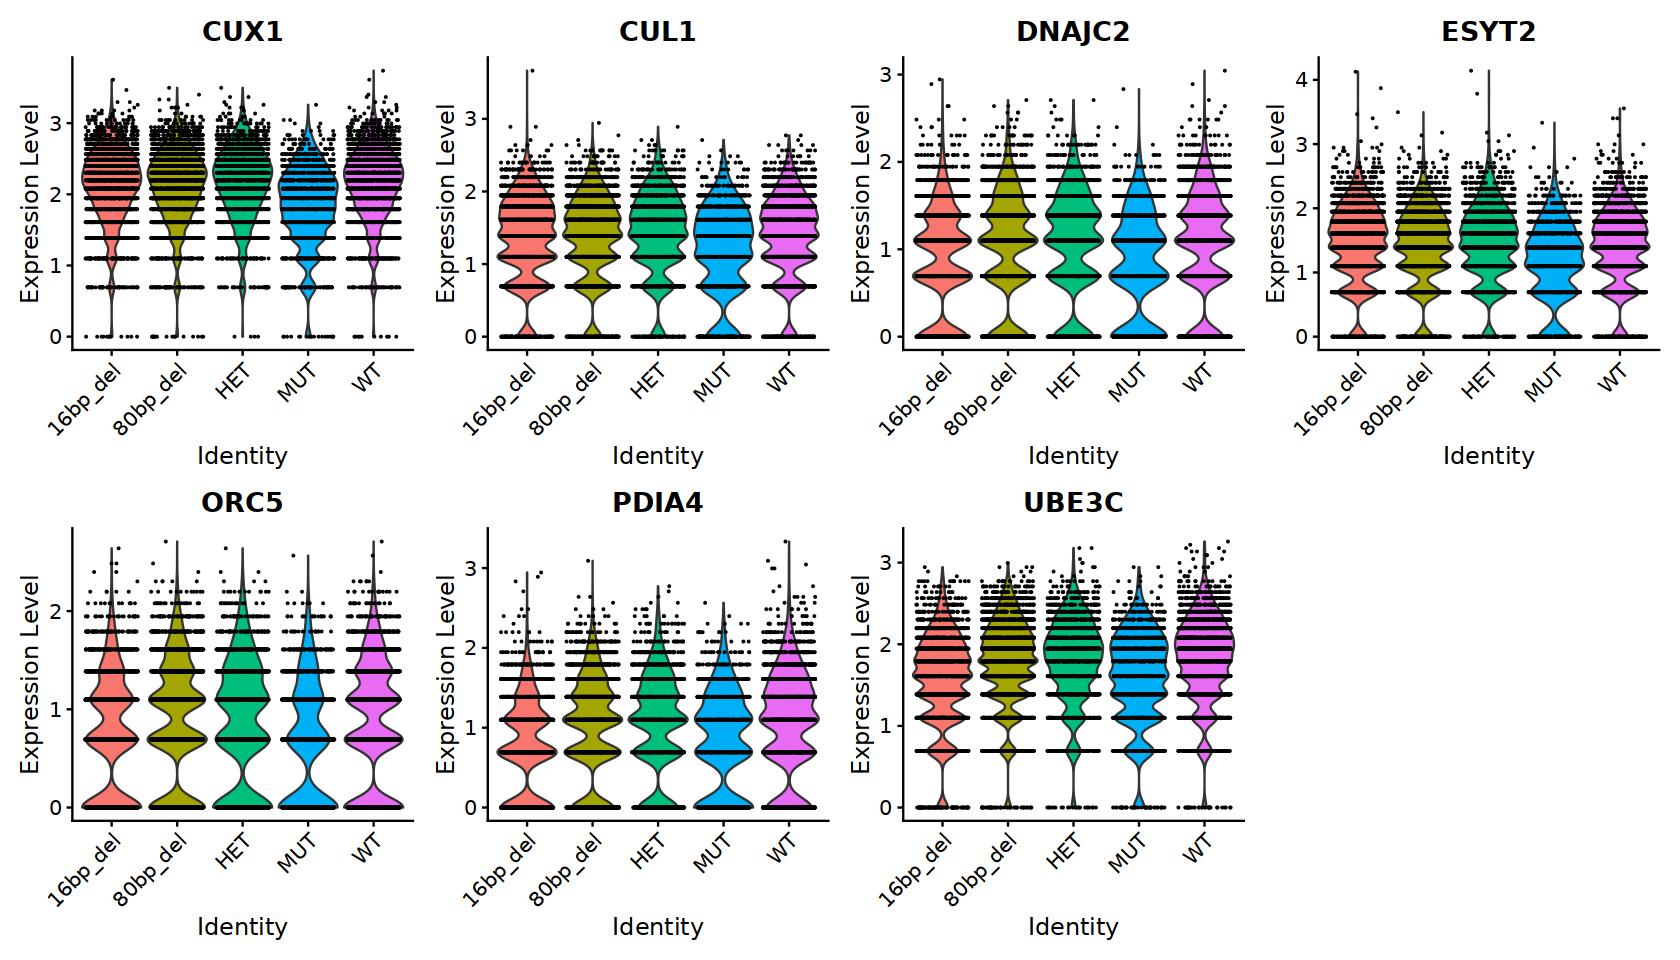

In [125]:
VlnPlot(adata2,
        
        features = c("CUX1", mm[mm$p_val_adj<0.1& mm$fdr<0.1,1]),  group.by = "Assigned_GFPgenotype", ncol = 4) 

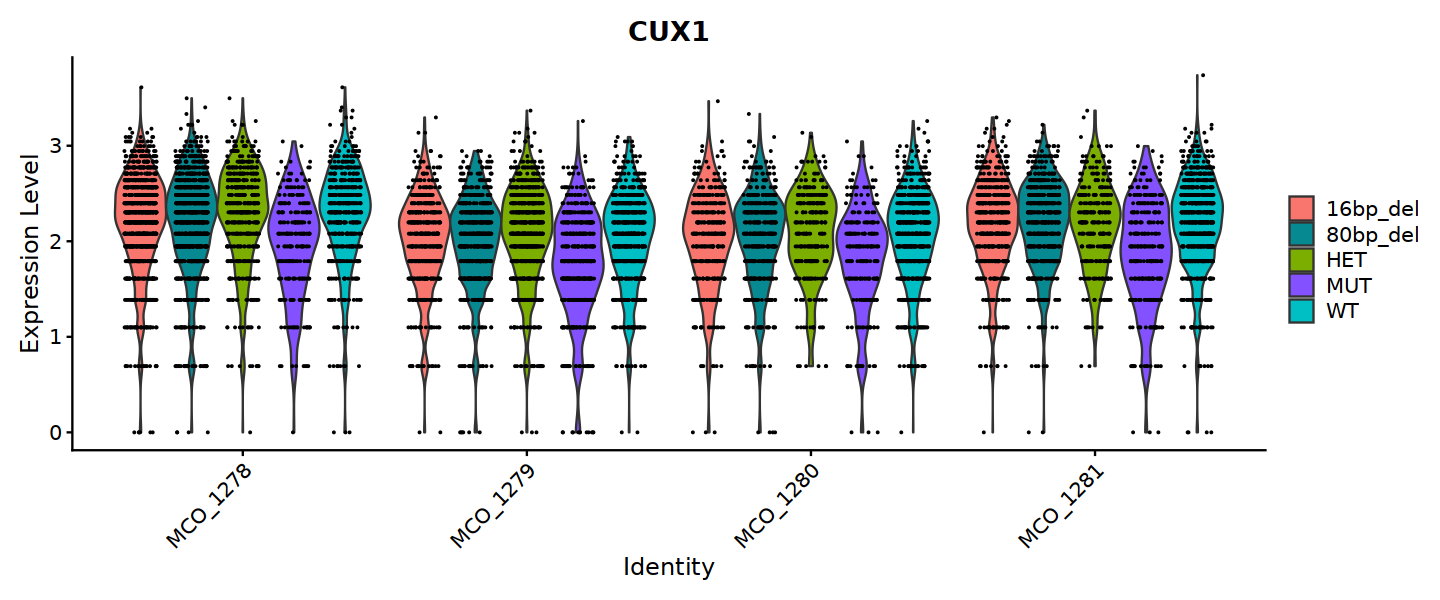

In [129]:
options(repr.plot.width = 12, repr.plot.height = 5)
VlnPlot(adata2,group.by = "orig.ident",features = "CUX1",  split.by = "Assigned_GFPgenotype") 

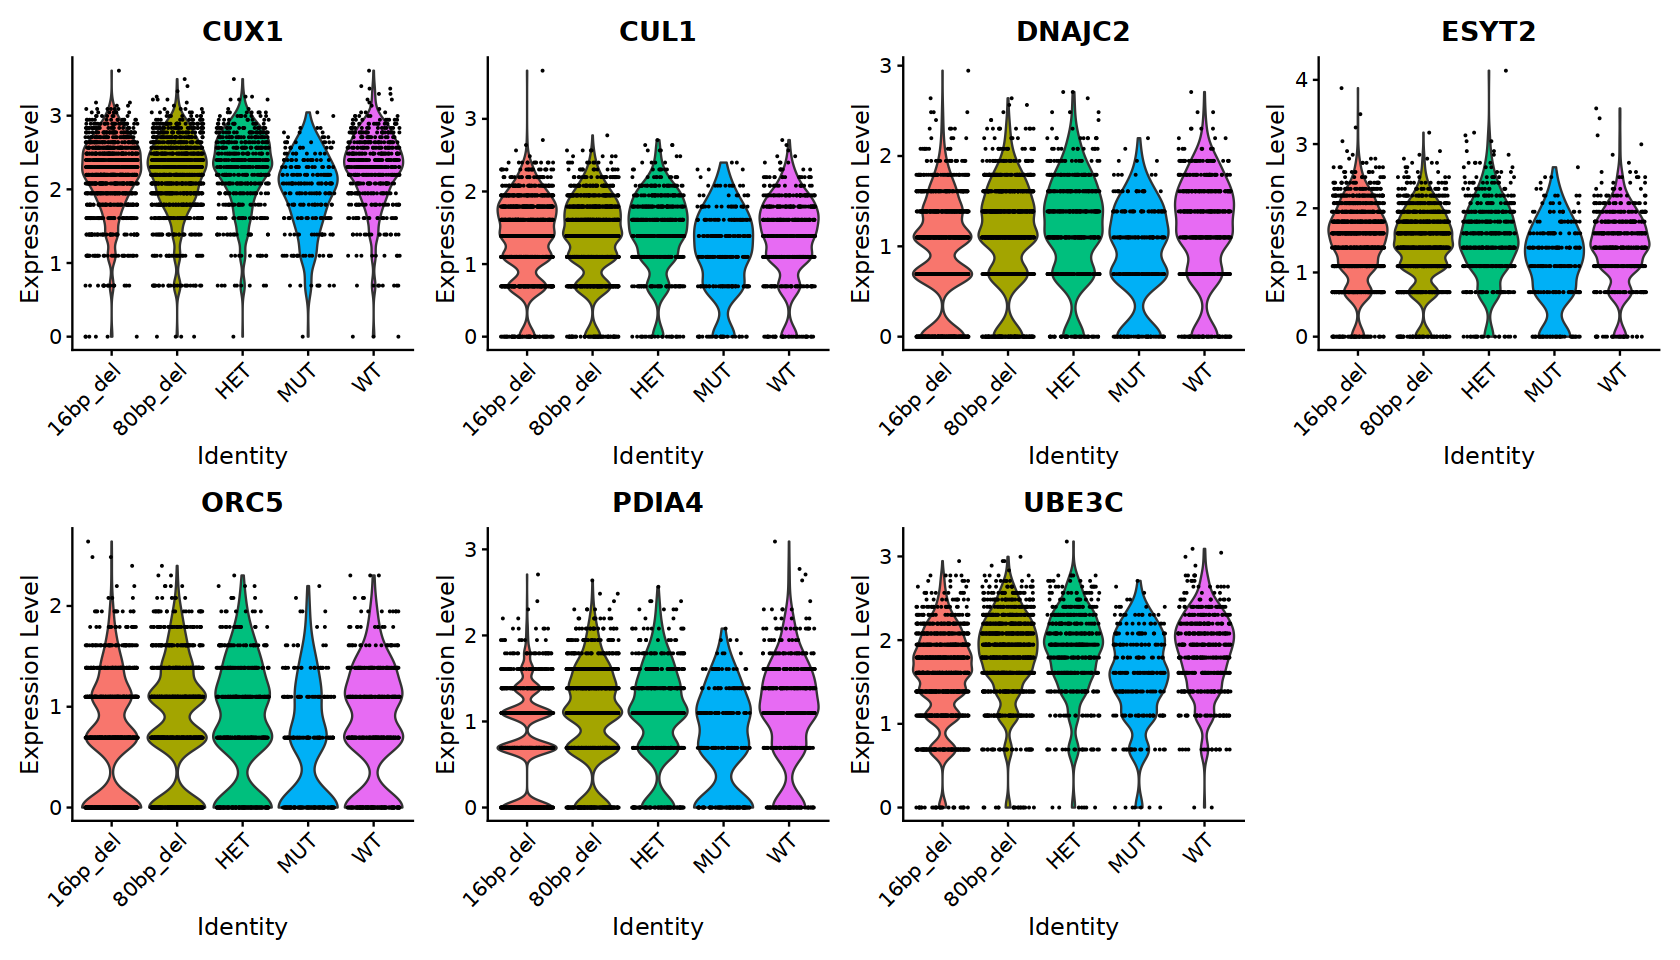

In [124]:
VlnPlot(subset(adata2,subset=orig.ident=="MCO_1278"), 
        
        features = c("CUX1", mm[mm$p_val_adj<0.1& mm$fdr<0.1,1]),  group.by = "Assigned_GFPgenotype", ncol = 4) 

### Ignore:Perform integration as below (using harmony in this case) if batch effects are found

In [ ]:
# RNA analysis
DefaultAssay(adata) <- 'RNA'
adata <- SCTransform(adata, verbose=FALSE)
adata <- RunPCA(adata)
adata <- RunHarmony(adata, group.by.vars='orig.ident', assay.use='SCT', reduction.save='harmony.rna')
adata <- RunUMAP(adata, dims=1:50, reduction='harmony.rna', reduction.name='umap.rna', reduction.key='rnaUMAP_')


# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata) <- 'ATAC'
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
adata <- RunSVD(adata)
hm_atac <- HarmonyMatrix(Embeddings(adata, reduction='lsi'), adata$library, do_pca=FALSE)
adata[['harmony.atac']] <- CreateDimReducObject(embeddings=hm_atac, key='atac_', assay='ATAC')
adata <- RunUMAP(adata, dims=2:50, reduction='harmony.atac', reduction.name='umap.atac', reduction.key='atacUMAP_')
#adata <- RunUMAP(adata, dims=2:50, reduction='lsi', reduction.name='umap.atac', reduction.key='atacUMAP_')

#adata <- FindMultiModalNeighbors(adata, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata <- FindMultiModalNeighbors(adata, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata <- FindClusters(adata, graph.name='wsnn', algorithm=4,  resolution = 0.5, verbose=FALSE)

saveRDS(adata, file = file.path(output_dir,'merged_integrated_clustered.rds'))


